## Minesweeper RL: Dueling Double DQN Agent with Visualizations

This notebook trains a powerful Reinforcement Learning agent to play Minesweeper using a Dueling Double DQN with a convolutional network. It includes:

- A  Minesweeper environment with flood-fill reveals and optional first-click safety
- A Dueling Double DQN agent with a target network, action masking, experience replay, and epsilon-greedy exploration
- Training metrics: rewards, win-rate, episode length, epsilon
-  visualizations


this is juts a first draft for leaning purposes



In [3]:

pip install tensorflow==2.15.0 gym==0.26.2 seaborn matplotlib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.7/721.7 kB 9.5 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.3/475.3 MB 1.3 MB/s eta 0:00:00:00:010:03m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 52.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 36.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 21.7 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 54.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.4/77.4 kB 5.2 MB/s eta 0:00:00
  Created wheel for gym: filenam

In [18]:
# Setup
import os
import math
import time
import random
from collections import deque, defaultdict
from dataclasses import dataclass

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses

# Reproducibility
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

# Plot styling
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)

print(tf.__version__)


2.15.0


In [19]:
# Improved Minesweeper Environment with Better Rewards

from gym import spaces

class MinesweeperEnv:
    """
    Enhanced Minesweeper environment with improved reward structure:
      - Progressive revealing rewards that encourage strategic play
      - Heavy penalties for poor actions
      - Dense reward shaping for better learning
    """
    def __init__(self, height=9, width=9, num_mines=10, first_click_safe=True, seed=None):
        self.height = height
        self.width = width
        self.num_mines = num_mines
        self.first_click_safe = first_click_safe
        self.rng = np.random.RandomState(seed)

        self.action_space = spaces.Discrete(self.height * self.width)
        # Enhanced observation with safety indicators
        self.observation_space = spaces.Box(low=0.0, high=1.0, shape=(self.height, self.width, 13), dtype=np.float32)

        self.reset()

    def reset(self):
        self.mines = np.zeros((self.height, self.width), dtype=bool)
        self.revealed = np.zeros((self.height, self.width), dtype=bool)
        self.flagged = np.zeros((self.height, self.width), dtype=bool)
        self.neighbor_counts = np.zeros((self.height, self.width), dtype=np.int8)
        self.num_safe_cells = self.height * self.width - self.num_mines
        self.revealed_safe = 0
        self.done = False
        self.first_action_done = False
        self.total_reward = 0.0
        self.steps = 0
        # Track consecutive safe reveals for bonus
        self.consecutive_safe = 0
        return self._get_obs()

    def _place_mines(self, safe_r=None, safe_c=None):
        positions = [(r, c) for r in range(self.height) for c in range(self.width)]
        if self.first_click_safe and safe_r is not None:
            # More generous safe zone around first click
            excl = set()
            for rr in range(max(0, safe_r-2), min(self.height, safe_r+3)):
                for cc in range(max(0, safe_c-2), min(self.width, safe_c+3)):
                    excl.add((rr, cc))
            positions = [pos for pos in positions if pos not in excl]
        self.rng.shuffle(positions)
        for (r, c) in positions[: self.num_mines]:
            self.mines[r, c] = True
        # Neighbor counts
        for r in range(self.height):
            for c in range(self.width):
                if self.mines[r, c]:
                    self.neighbor_counts[r, c] = -1
                else:
                    self.neighbor_counts[r, c] = self._count_neighbors(r, c)

    def _count_neighbors(self, r, c):
        count = 0
        for rr in range(max(0, r-1), min(self.height, r+2)):
            for cc in range(max(0, c-1), min(self.width, c+2)):
                if rr == r and cc == c:
                    continue
                if self.mines[rr, cc]:
                    count += 1
        return count

    def _flood_fill(self, r, c):
        stack = [(r, c)]
        newly_revealed = []
        while stack:
            rr, cc = stack.pop()
            if self.revealed[rr, cc]:
                continue
            self.revealed[rr, cc] = True
            newly_revealed.append((rr, cc))
            if self.neighbor_counts[rr, cc] == 0:
                for nr in range(max(0, rr-1), min(self.height, rr+2)):
                    for nc in range(max(0, cc-1), min(self.width, cc+2)):
                        if not self.revealed[nr, nc] and not self.mines[nr, nc]:
                            stack.append((nr, nc))
        return newly_revealed

    def _calculate_progress_reward(self, newly_revealed_count):
        """Enhanced progress-based reward"""
        base_reward = newly_revealed_count * 2.0  # Higher base reward
        
        # Bonus for consecutive safe reveals
        self.consecutive_safe += newly_revealed_count
        consecutive_bonus = min(self.consecutive_safe * 0.5, 10.0)
        
        # Progress bonus - more reward as we get closer to winning
        progress = self.revealed_safe / self.num_safe_cells
        progress_bonus = progress * 15.0  # Increasing reward as we approach win
        
        # Efficiency bonus - reward fewer steps
        efficiency_bonus = max(0, (self.num_safe_cells - self.steps) * 0.1)
        
        return base_reward + consecutive_bonus + progress_bonus + efficiency_bonus

    def step(self, action):
        if self.done:
            return self._get_obs(), 0.0, True, {}

        self.steps += 1
        r, c = divmod(int(action), self.width)

        # Lazy mine placement on first action
        if not self.first_action_done:
            self._place_mines(safe_r=r, safe_c=c)
            self.first_action_done = True

        reward = 0.0
        info = {}

        # Heavy penalty for clicking already revealed cells
        if self.revealed[r, c]:
            reward = -5.0  # Much higher penalty
            self.consecutive_safe = 0  # Reset streak
            return self._get_obs(), reward, False, info

        # Mine hit - game over with severe penalty
        if self.mines[r, c]:
            self.revealed[r, c] = True
            self.done = True
            # Penalty based on how much progress was made
            progress_penalty = -(50.0 - self.revealed_safe * 2.0)
            reward = progress_penalty
            self.consecutive_safe = 0
            return self._get_obs(), reward, True, info

        # Safe cell reveal
        before = np.sum(self.revealed)
        newly = self._flood_fill(r, c)
        after = np.sum(self.revealed)
        gained = after - before
        self.revealed_safe += gained

        # Calculate sophisticated reward
        reward = self._calculate_progress_reward(gained)
        
        # Small step penalty to encourage efficiency
        reward -= 0.05

        # Win condition with massive bonus
        if self.revealed_safe >= self.num_safe_cells:
            self.done = True
            # Win bonus scales with efficiency
            win_bonus = 100.0 + max(0, (self.num_safe_cells - self.steps) * 2.0)
            reward += win_bonus

        self.total_reward += reward
        return self._get_obs(), reward, self.done, info

    def _get_obs(self):
        H, W = self.height, self.width
        # Enhanced observation with safety and mine probability indicators
        obs = np.zeros((H, W, 13), dtype=np.float32)
        obs[..., 0] = self.revealed.astype(np.float32)
        obs[..., 1] = self.flagged.astype(np.float32)
        
        # One-hot encoding for neighbor counts (0-8)
        for r in range(H):
            for c in range(W):
                if self.revealed[r, c]:
                    count = int(self.neighbor_counts[r, c])
                    if count < 0:
                        count = 0
                    obs[r, c, 2 + count] = 1.0
        
        # Safety indicator channel - helps agent identify safer moves
        obs[..., 11] = self._compute_safety_map()
        
        # Progress indicator - normalized progress towards win
        obs[..., 12] = self.revealed_safe / self.num_safe_cells
        
        return obs
    
    def _compute_safety_map(self):
        """Compute relative safety of unrevealed cells based on revealed neighbors"""
        safety = np.zeros((self.height, self.width), dtype=np.float32)
        
        for r in range(self.height):
            for c in range(self.width):
                if not self.revealed[r, c]:
                    # Count revealed neighbors and their mine counts
                    revealed_neighbors = 0
                    total_neighbor_mines = 0
                    
                    for rr in range(max(0, r-1), min(self.height, r+2)):
                        for cc in range(max(0, c-1), min(self.width, c+2)):
                            if rr == r and cc == c:
                                continue
                            if self.revealed[rr, cc]:
                                revealed_neighbors += 1
                                if self.neighbor_counts[rr, cc] >= 0:
                                    total_neighbor_mines += self.neighbor_counts[rr, cc]
                    
                    # Higher safety for cells near revealed cells with low mine counts
                    if revealed_neighbors > 0:
                        avg_neighbor_mines = total_neighbor_mines / revealed_neighbors
                        safety[r, c] = max(0, 1.0 - avg_neighbor_mines / 8.0)
                    else:
                        safety[r, c] = 0.5  # Neutral for unexplored areas
        
        return safety

    def render_ascii(self, reveal_mines_when_done=True):
        H, W = self.height, self.width
        board = []
        for r in range(H):
            row = []
            for c in range(W):
                if self.revealed[r, c]:
                    if self.mines[r, c]:
                        row.append('*')
                    else:
                        cnt = self.neighbor_counts[r, c]
                        row.append(str(cnt))
                else:
                    if reveal_mines_when_done and self.done and self.mines[r, c]:
                        row.append('M')
                    else:
                        row.append('□')
            board.append(' '.join(row))
        print('\n'.join(board))

    def valid_action_mask(self):
        # Mask invalid actions (already revealed cells)
        mask = (~self.revealed).astype(np.float32)
        return mask.reshape(-1)

    def sample_random_action(self):
        # Sample only unrevealed cells
        unrevealed = np.argwhere(~self.revealed)
        if len(unrevealed) == 0:
            return 0
        idx = self.rng.randint(len(unrevealed))
        r, c = unrevealed[idx]
        return r * self.width + c

In [22]:
# Utilities: plotting and rendering

def plot_training_curves(history):
	fig, axes = plt.subplots(2, 2, figsize=(12, 8))
	metrics = [
		("episode_reward", "Total Reward"),
		("win_rate", "Win Rate (moving avg)"),
		("episode_length", "Episode Length"),
		("epsilon", "Epsilon")
	]
	for ax, (k, title) in zip(axes.ravel(), metrics):
		ax.plot(history[k])
		ax.set_title(title)
		ax.set_xlabel("Episode")
		ax.grid(True)
	plt.tight_layout()
	plt.show()


def render_board_image(env: MinesweeperEnv, show_mines_when_done=True):
	H, W = env.height, env.width
	img = np.zeros((H, W, 3), dtype=np.float32)
	for r in range(H):
		for c in range(W):
			if env.revealed[r, c]:
				cnt = env.neighbor_counts[r, c]
				color = (0.85, 0.95, 1.0)
				img[r, c] = color
			else:
				img[r, c] = (0.6, 0.7, 0.8)
				if env.done and show_mines_when_done and env.mines[r, c]:
					img[r, c] = (0.9, 0.2, 0.2)
	return img


def show_board(env):
	img = render_board_image(env)
	plt.figure(figsize=(5, 5))
	plt.imshow(img, interpolation="nearest")
	plt.xticks(range(env.width))
	plt.yticks(range(env.height))
	plt.grid(color='k', linestyle=':', linewidth=0.5)
	plt.title("Minesweeper Board")
	plt.show()


def heatmap_q_values(q_values, env: MinesweeperEnv, title="Q-Values Heatmap"):
	H, W = env.height, env.width
	grid = q_values.reshape(H, W)
	plt.figure(figsize=(5, 5))
	sns.heatmap(grid, annot=False, cmap="viridis")
	plt.title(title)
	plt.show()


In [23]:
# Dueling Double DQN Agent

@dataclass
class DQNConfig:
	learning_rate: float = 1e-3
	gamma: float = 0.99
	target_update_every: int = 100
	batch_size: int = 64
	replay_capacity: int = 100_000
	epsilon_start: float = 1.0
	epsilon_end: float = 0.05
	epsilon_decay_episodes: int = 800
	conv_channels: int = 32
	fc_units: int = 128


def build_dueling_cnn(input_shape, num_actions, conv_channels=32, fc_units=128):
	inputs = layers.Input(shape=input_shape)
	# Feature extractor
	x = layers.Conv2D(conv_channels, kernel_size=3, padding="same", activation="relu")(inputs)
	x = layers.Conv2D(conv_channels, kernel_size=3, padding="same", activation="relu")(x)
	x = layers.Conv2D(conv_channels, kernel_size=3, padding="same", activation="relu")(x)
	x = layers.Flatten()(x)
	# Dueling heads
	value = layers.Dense(fc_units, activation="relu")(x)
	value = layers.Dense(1)(value)
	adv = layers.Dense(fc_units, activation="relu")(x)
	adv = layers.Dense(num_actions)(adv)
	# Q = V + (A - mean(A))
	adv_mean = layers.Lambda(lambda a: tf.reduce_mean(a, axis=1, keepdims=True))(adv)
	q_values = layers.Add()([value, layers.Subtract()([adv, adv_mean])])
	model = models.Model(inputs=inputs, outputs=q_values)
	return model


class ReplayBuffer:
	def __init__(self, capacity, obs_shape):
		self.capacity = capacity
		self.obs_shape = obs_shape
		self.states = np.zeros((capacity, *obs_shape), dtype=np.float32)
		self.next_states = np.zeros((capacity, *obs_shape), dtype=np.float32)
		self.actions = np.zeros((capacity,), dtype=np.int32)
		self.rewards = np.zeros((capacity,), dtype=np.float32)
		self.dones = np.zeros((capacity,), dtype=np.float32)
		self.index = 0
		self.size = 0

	def add(self, s, a, r, ns, d):
		idx = self.index % self.capacity
		self.states[idx] = s
		self.next_states[idx] = ns
		self.actions[idx] = a
		self.rewards[idx] = r
		self.dones[idx] = float(d)
		self.index += 1
		self.size = min(self.size + 1, self.capacity)

	def sample(self, batch_size):
		idxs = np.random.randint(0, self.size, size=batch_size)
		return (
			self.states[idxs],
			self.actions[idxs],
			self.rewards[idxs],
			self.next_states[idxs],
			self.dones[idxs],
		)


class DuelingDoubleDQN:
	def __init__(self, obs_shape, num_actions, config: DQNConfig):
		self.num_actions = num_actions
		self.config = config
		self.online = build_dueling_cnn(obs_shape, num_actions, config.conv_channels, config.fc_units)
		self.target = build_dueling_cnn(obs_shape, num_actions, config.conv_channels, config.fc_units)
		self.target.set_weights(self.online.get_weights())
		self.optimizer = optimizers.Adam(learning_rate=config.learning_rate)
		self.loss_fn = losses.Huber()

		self.replay = ReplayBuffer(config.replay_capacity, obs_shape)
		self.train_step_count = 0

	def select_action(self, state, valid_mask, epsilon):
		if np.random.rand() < epsilon:
			# masked random
			probs = valid_mask / (valid_mask.sum() + 1e-8)
			return np.random.choice(self.num_actions, p=probs)
		q = self.online.predict(state[None, ...], verbose=0)[0]
		# mask invalid actions by -inf
		masked_q = np.where(valid_mask > 0.5, q, -1e9)
		return int(np.argmax(masked_q))

	@tf.function
	def _train_step(self, states, actions, rewards, next_states, dones):
		# Double DQN: action selection by online, eval by target
		online_q_next = self.online(next_states, training=False)
		next_actions = tf.argmax(online_q_next, axis=1)
		target_q_next = self.target(next_states, training=False)
		target_q_next = tf.gather(target_q_next, next_actions, batch_dims=1)
		y = rewards + self.config.gamma * (1.0 - dones) * target_q_next
		with tf.GradientTape() as tape:
			q_values = self.online(states, training=True)
			pred = tf.gather(q_values, actions, batch_dims=1)
			loss = self.loss_fn(y, pred)
		grads = tape.gradient(loss, self.online.trainable_variables)
		self.optimizer.apply_gradients(zip(grads, self.online.trainable_variables))
		return loss

	def train_on_batch(self):
		if self.replay.size < self.config.batch_size:
			return None
		batch = self.replay.sample(self.config.batch_size)
		loss = self._train_step(*[tf.convert_to_tensor(x) for x in batch])
		self.train_step_count += 1
		if self.train_step_count % self.config.target_update_every == 0:
			self.target.set_weights(self.online.get_weights())
		return float(loss.numpy())


In [24]:
# Enhanced Dueling Double DQN Agent with Prioritized Replay

@dataclass
class DQNConfig:
	learning_rate: float = 3e-4
	gamma: float = 0.995
	target_update_every: int = 500
	batch_size: int = 128
	replay_capacity: int = 200_000
	epsilon_start: float = 1.0
	epsilon_end: float = 0.02
	epsilon_decay_episodes: int = 1500
	conv_channels: int = 64
	fc_units: int = 256
	# Prioritized replay parameters
	alpha: float = 0.6  # Priority exponent
	beta_start: float = 0.4  # Importance sampling exponent
	beta_end: float = 1.0
	# Additional improvements
	gradient_clip: float = 10.0
	weight_decay: float = 1e-5


def build_enhanced_dueling_cnn(input_shape, num_actions, conv_channels=64, fc_units=256):
	"""Enhanced CNN with residual connections and attention mechanism"""
	inputs = layers.Input(shape=input_shape)
	
	# Initial feature extraction with larger receptive field
	x = layers.Conv2D(conv_channels, kernel_size=5, padding="same", activation="relu")(inputs)
	x = layers.BatchNormalization()(x)
	
	# Residual blocks for better feature learning
	for i in range(3):
		residual = x
		x = layers.Conv2D(conv_channels, kernel_size=3, padding="same", activation="relu")(x)
		x = layers.BatchNormalization()(x)
		x = layers.Conv2D(conv_channels, kernel_size=3, padding="same", activation="relu")(x)
		x = layers.BatchNormalization()(x)
		x = layers.Add()([x, residual])  # Residual connection
		x = layers.Activation("relu")(x)
	
	# Spatial attention mechanism
	attention = layers.Conv2D(1, kernel_size=1, activation="sigmoid", name="spatial_attention")(x)
	x = layers.Multiply()([x, attention])
	
	# Global average pooling + flatten for spatial information preservation
	gap = layers.GlobalAveragePooling2D()(x)
	flat = layers.Flatten()(x)
	x = layers.Concatenate()([gap, flat])
	
	# Enhanced dueling heads with dropout
	x = layers.Dense(fc_units, activation="relu")(x)
	x = layers.Dropout(0.3)(x)
	x = layers.Dense(fc_units // 2, activation="relu")(x)
	x = layers.Dropout(0.2)(x)
	
	# Value head
	value = layers.Dense(fc_units // 4, activation="relu")(x)
	value = layers.Dense(1, name="value")(value)
	
	# Advantage head
	adv = layers.Dense(fc_units // 2, activation="relu")(x)
	adv = layers.Dense(num_actions, name="advantage")(adv)
	
	# Dueling aggregation with learnable normalization
	adv_mean = layers.Lambda(lambda a: tf.reduce_mean(a, axis=1, keepdims=True))(adv)
	q_values = layers.Add(name="q_values")([value, layers.Subtract()([adv, adv_mean])])
	
	model = models.Model(inputs=inputs, outputs=q_values)
	return model


class PrioritizedReplayBuffer:
	"""Fixed Prioritized Experience Replay buffer with sum tree implementation"""
	def __init__(self, capacity, obs_shape, alpha=0.6):
		self.capacity = capacity
		self.obs_shape = obs_shape
		self.alpha = alpha
		self.max_priority = 1.0
		
		# Storage
		self.states = np.zeros((capacity, *obs_shape), dtype=np.float32)
		self.next_states = np.zeros((capacity, *obs_shape), dtype=np.float32)
		self.actions = np.zeros((capacity,), dtype=np.int32)
		self.rewards = np.zeros((capacity,), dtype=np.float32)
		self.dones = np.zeros((capacity,), dtype=np.float32)
		
		# Priority tree - fix size calculation
		tree_capacity = 1
		while tree_capacity < capacity:
			tree_capacity *= 2
		self.tree_capacity = tree_capacity
		self.tree = np.zeros(2 * tree_capacity - 1)
		
		self.index = 0
		self.size = 0

	def _update_tree(self, idx, priority):
		tree_idx = idx + self.tree_capacity - 1
		self.tree[tree_idx] = priority ** self.alpha
		
		while tree_idx != 0:
			tree_idx = (tree_idx - 1) // 2
			self.tree[tree_idx] = self.tree[2 * tree_idx + 1] + self.tree[2 * tree_idx + 2]

	def add(self, s, a, r, ns, d):
		idx = self.index % self.capacity
		self.states[idx] = s
		self.next_states[idx] = ns
		self.actions[idx] = a
		self.rewards[idx] = r
		self.dones[idx] = float(d)
		
		self._update_tree(idx, self.max_priority)
		
		self.index += 1
		self.size = min(self.size + 1, self.capacity)

	def _sample_proportional(self, batch_size):
		indices = []
		priorities = []
		segment = self.tree[0] / batch_size
		
		for i in range(batch_size):
			a = segment * i
			b = segment * (i + 1)
			s = np.random.uniform(a, b)
			idx = self._retrieve(0, s)
			# Ensure idx is within valid range
			idx = max(0, min(idx, self.tree_capacity - 1))
			indices.append(idx)
			priorities.append(self.tree[idx + self.tree_capacity - 1])
		
		return indices, priorities

	def _retrieve(self, idx, s):
		left = 2 * idx + 1
		right = left + 1
		
		if left >= len(self.tree):
			return idx
		
		if s <= self.tree[left]:
			return self._retrieve(left, s)
		else:
			return self._retrieve(right, s - self.tree[left])

	def sample(self, batch_size, beta=0.4):
		if self.size < batch_size:
			# Fallback to uniform sampling if not enough data
			indices = np.random.randint(0, self.size, size=batch_size)
			weights = np.ones(batch_size)
			return (
				self.states[indices],
				self.actions[indices],
				self.rewards[indices],
				self.next_states[indices],
				self.dones[indices],
				weights,
				indices
			)
		
		indices, priorities = self._sample_proportional(batch_size)
		
		# Convert tree indices to buffer indices and clamp to valid range
		buffer_indices = [min(max(0, idx), self.size - 1) for idx in indices]
		
		# Importance sampling weights
		priorities = np.array(priorities)
		priorities = np.maximum(priorities, 1e-8)  # Avoid division by zero
		weights = (self.size * priorities) ** (-beta)
		weights /= weights.max()
		
		return (
			self.states[buffer_indices],
			self.actions[buffer_indices],
			self.rewards[buffer_indices],
			self.next_states[buffer_indices],
			self.dones[buffer_indices],
			weights,
			buffer_indices
		)

	def update_priorities(self, indices, priorities):
		for idx, priority in zip(indices, priorities):
			if 0 <= idx < self.capacity:  # Safety check
				self.max_priority = max(self.max_priority, priority)
				self._update_tree(idx, priority)


class EnhancedDuelingDoubleDQN:
	def __init__(self, obs_shape, num_actions, config: DQNConfig):
		self.num_actions = num_actions
		self.config = config
		
		# Build networks
		self.online = build_enhanced_dueling_cnn(obs_shape, num_actions, config.conv_channels, config.fc_units)
		self.target = build_enhanced_dueling_cnn(obs_shape, num_actions, config.conv_channels, config.fc_units)
		self.target.set_weights(self.online.get_weights())
		
		# Optimizer with weight decay
		self.optimizer = optimizers.AdamW(
			learning_rate=config.learning_rate,
			weight_decay=config.weight_decay
		)
		self.loss_fn = losses.Huber(delta=1.0)

		# Prioritized replay buffer
		self.replay = PrioritizedReplayBuffer(config.replay_capacity, obs_shape, config.alpha)
		self.train_step_count = 0
		
		# For beta annealing
		self.beta_start = config.beta_start
		self.beta_end = config.beta_end

	def select_action(self, state, valid_mask, epsilon):
		if np.random.rand() < epsilon:
			# Safety-weighted random action
			safety_scores = state[..., 11].flatten()  # Safety channel
			combined_probs = valid_mask * (1.0 + safety_scores)  # Bias towards safer cells
			combined_probs = combined_probs / (combined_probs.sum() + 1e-8)
			return np.random.choice(self.num_actions, p=combined_probs)
		
		q = self.online.predict(state[None, ...], verbose=0)[0]
		# Mask invalid actions and add safety bias
		safety_scores = state[..., 11].flatten()
		safety_bias = safety_scores * 0.1  # Small safety bias even for greedy actions
		masked_q = np.where(valid_mask > 0.5, q + safety_bias, -1e9)
		return int(np.argmax(masked_q))

	def get_beta(self, episode, max_episodes):
		"""Linearly anneal beta from beta_start to beta_end"""
		fraction = min(episode / max_episodes, 1.0)
		return self.beta_start + fraction * (self.beta_end - self.beta_start)

	@tf.function
	def _train_step(self, states, actions, rewards, next_states, dones, weights):
		# Double DQN with importance sampling
		online_q_next = self.online(next_states, training=False)
		next_actions = tf.argmax(online_q_next, axis=1)
		target_q_next = self.target(next_states, training=False)
		target_q_next = tf.gather(target_q_next, next_actions, batch_dims=1)
		y = rewards + self.config.gamma * (1.0 - dones) * target_q_next
		
		with tf.GradientTape() as tape:
			q_values = self.online(states, training=True)
			pred = tf.gather(q_values, actions, batch_dims=1)
			td_errors = y - pred
			loss = tf.reduce_mean(weights * self.loss_fn(y, pred))
		
		# Gradient clipping
		grads = tape.gradient(loss, self.online.trainable_variables)
		grads, _ = tf.clip_by_global_norm(grads, self.config.gradient_clip)
		self.optimizer.apply_gradients(zip(grads, self.online.trainable_variables))
		
		return loss, td_errors

	def train_on_batch(self, episode=0, max_episodes=1000):
		if self.replay.size < self.config.batch_size:
			return None
			
		beta = self.get_beta(episode, max_episodes)
		states, actions, rewards, next_states, dones, weights, indices = self.replay.sample(
			self.config.batch_size, beta
		)
		
		loss, td_errors = self._train_step(
			tf.convert_to_tensor(states),
			tf.convert_to_tensor(actions),
			tf.convert_to_tensor(rewards),
			tf.convert_to_tensor(next_states),
			tf.convert_to_tensor(dones),
			tf.convert_to_tensor(weights, dtype=tf.float32)
		)
		
		# Update priorities
		priorities = np.abs(td_errors.numpy()) + 1e-6
		self.replay.update_priorities(indices, priorities)
		
		self.train_step_count += 1
		if self.train_step_count % self.config.target_update_every == 0:
			self.target.set_weights(self.online.get_weights())
		
		return float(loss.numpy())

In [25]:
# Enhanced Training loop with curriculum learning

def linear_epsilon(eps, eps_end, frac):
	return max(eps_end, eps - (eps - eps_end) * frac)


def exponential_epsilon(eps_start, eps_end, frac, decay_rate=5.0):
	"""Exponential epsilon decay for better exploration schedule"""
	return eps_end + (eps_start - eps_end) * np.exp(-decay_rate * frac)


def moving_average(x, k=50):
	if len(x) == 0:
		return []
	x_arr = np.array(x, dtype=np.float32)
	if len(x_arr) < k:
		return list(np.convolve(x_arr, np.ones(len(x_arr))/len(x_arr), mode='valid'))
	return list(np.convolve(x_arr, np.ones(k)/k, mode='valid'))


def train_enhanced_agent(
	env: MinesweeperEnv,
	episodes=2500,
	warmup_steps=2000,
	max_steps_per_episode=None,
	config=DQNConfig(),
	show_progress_every=100,
	curriculum_learning=True,
):
	"""Enhanced training with curriculum learning and early success detection"""
	obs_shape = env.observation_space.shape
	num_actions = env.action_space.n
	agent = EnhancedDuelingDoubleDQN(obs_shape, num_actions, config)

	# History tracking
	history = defaultdict(list)
	best_winrate = 0.0
	recent_wins = deque(maxlen=50)  # Track recent performance
	
	# Curriculum learning: start with easier settings if enabled
	if curriculum_learning:
		original_mines = env.num_mines
		# Start with fewer mines for easier learning
		env.num_mines = max(3, env.num_mines // 2)
		curriculum_phase = 0
		phase_episodes = episodes // 3
		print(f"Starting curriculum with {env.num_mines} mines")

	epsilon = config.epsilon_start
	consecutive_good_episodes = 0
	
	for ep in range(episodes):
		# Curriculum progression
		if curriculum_learning:
			if ep == phase_episodes and curriculum_phase == 0:
				env.num_mines = original_mines * 3 // 4
				curriculum_phase = 1
				print(f"Curriculum phase 2: {env.num_mines} mines")
			elif ep == 2 * phase_episodes and curriculum_phase == 1:
				env.num_mines = original_mines
				curriculum_phase = 2
				print(f"Curriculum phase 3: {env.num_mines} mines (full difficulty)")
		
		state = env.reset()
		done = False
		ep_reward = 0.0
		steps = 0
		if max_steps_per_episode is None:
			max_steps_per_episode = env.height * env.width * 2  # More generous step limit

		# Episode loop
		while not done and steps < max_steps_per_episode:
			valid_mask = env.valid_action_mask()
			action = agent.select_action(state, valid_mask, epsilon)
			next_state, reward, done, _ = env.step(action)
			ep_reward += reward
			agent.replay.add(state, action, reward, next_state, done)
			state = next_state
			steps += 1

			# Train after warmup with proper episode tracking
			if agent.replay.size > max(config.batch_size, warmup_steps):
				loss = agent.train_on_batch(episode=ep, max_episodes=episodes)

		# Adaptive epsilon decay based on performance
		if len(recent_wins) >= 10 and np.mean(recent_wins) > 0.1:
			# Faster decay if we're learning
			frac = (ep + 1) / max(1, config.epsilon_decay_episodes * 0.7)
		else:
			# Standard decay
			frac = (ep + 1) / max(1, config.epsilon_decay_episodes)
		
		epsilon = exponential_epsilon(config.epsilon_start, config.epsilon_end, frac)

		# Enhanced metrics tracking
		win = float(env.revealed_safe >= env.num_safe_cells and env.done)
		recent_wins.append(win)
		
		history["episode_reward"].append(ep_reward)
		history["episode_length"].append(steps)
		history["win"].append(win)
		history["epsilon"].append(epsilon)
		
		# Compute moving averages
		win_rate_100 = np.mean(history["win"][-100:])
		win_rate_50 = np.mean(history["win"][-50:]) if len(history["win"]) >= 50 else win_rate_100
		
		history["win_rate"].append(win_rate_100)
		history["win_rate_50"].append(win_rate_50)
		
		# Track best performance
		if win_rate_50 > best_winrate:
			best_winrate = win_rate_50
			consecutive_good_episodes = 0
		else:
			consecutive_good_episodes += 1

		# Progress reporting
		if (ep + 1) % show_progress_every == 0:
			avg_reward = np.mean(history["episode_reward"][-show_progress_every:])
			avg_steps = np.mean(history["episode_length"][-show_progress_every:])
			print(f"Episode {ep+1}/{episodes} | Reward {avg_reward:.1f} | Steps {avg_steps:.1f} | "
				  f"WinRate@50 {win_rate_50:.3f} | WinRate@100 {win_rate_100:.3f} | "
				  f"Eps {epsilon:.3f} | Mines {env.num_mines}")
		
		# Early stopping if we achieve very good performance
		if win_rate_50 >= 0.8 and len(history["win"]) >= 200:
			print(f"Early stopping: Achieved {win_rate_50:.3f} win rate!")
			break

	return agent, history


# Evaluation utilities
def evaluate_agent(env, agent, num_games=100, render_failures=False):
	"""Comprehensive agent evaluation"""
	wins = 0
	total_steps = 0
	total_rewards = 0
	game_lengths = []
	
	for i in range(num_games):
		state = env.reset()
		done = False
		steps = 0
		ep_reward = 0
		
		while not done and steps < env.height * env.width * 2:
			valid_mask = env.valid_action_mask()
			# Greedy evaluation
			q = agent.online.predict(state[None, ...], verbose=0)[0]
			masked_q = np.where(valid_mask > 0.5, q, -1e9)
			action = int(np.argmax(masked_q))
			
			state, reward, done, _ = env.step(action)
			ep_reward += reward
			steps += 1
		
		win = env.revealed_safe >= env.num_safe_cells and env.done
		if win:
			wins += 1
		elif render_failures and i < 5:  # Show first few failures
			print(f"Game {i+1} failed after {steps} steps (reward: {ep_reward:.1f})")
			env.render_ascii()
			print()
		
		total_steps += steps
		total_rewards += ep_reward
		game_lengths.append(steps)
	
	win_rate = wins / num_games
	avg_steps = total_steps / num_games
	avg_reward = total_rewards / num_games
	
	print(f"Evaluation over {num_games} games:")
	print(f"Win Rate: {win_rate:.3f}")
	print(f"Average Steps: {avg_steps:.1f}")
	print(f"Average Reward: {avg_reward:.1f}")
	print(f"Step Distribution: min={min(game_lengths)}, max={max(game_lengths)}, std={np.std(game_lengths):.1f}")
	
	return win_rate, avg_steps, avg_reward

Training on 8x8 board with 10 mines
Safe cells to reveal: 54
Configuration:
- Network: 64 conv channels, 256 FC units
- Learning rate: 0.0003
- Replay buffer: 200,000 experiences
- Prioritized replay: α=0.6, β=0.4→1.0
- Episodes: 2500 with curriculum learning

Starting curriculum with 5 mines
Episode 100/2500 | Reward 224.8 | Steps 3.3 | WinRate@50 0.080 | WinRate@100 0.040 | Eps 0.722 | Mines 5
Episode 200/2500 | Reward 235.4 | Steps 3.5 | WinRate@50 0.020 | WinRate@100 0.020 | Eps 0.523 | Mines 5
Episode 300/2500 | Reward 228.0 | Steps 3.2 | WinRate@50 0.060 | WinRate@100 0.050 | Eps 0.381 | Mines 5
Episode 400/2500 | Reward 229.4 | Steps 3.4 | WinRate@50 0.000 | WinRate@100 0.030 | Eps 0.278 | Mines 5
Episode 500/2500 | Reward 231.0 | Steps 3.3 | WinRate@50 0.000 | WinRate@100 0.030 | Eps 0.205 | Mines 5
Episode 600/2500 | Reward 225.4 | Steps 3.4 | WinRate@50 0.080 | WinRate@100 0.060 | Eps 0.153 | Mines 5
Episode 700/2500 | Reward 228.5 | Steps 3.3 | WinRate@50 0.040 | WinRate@100

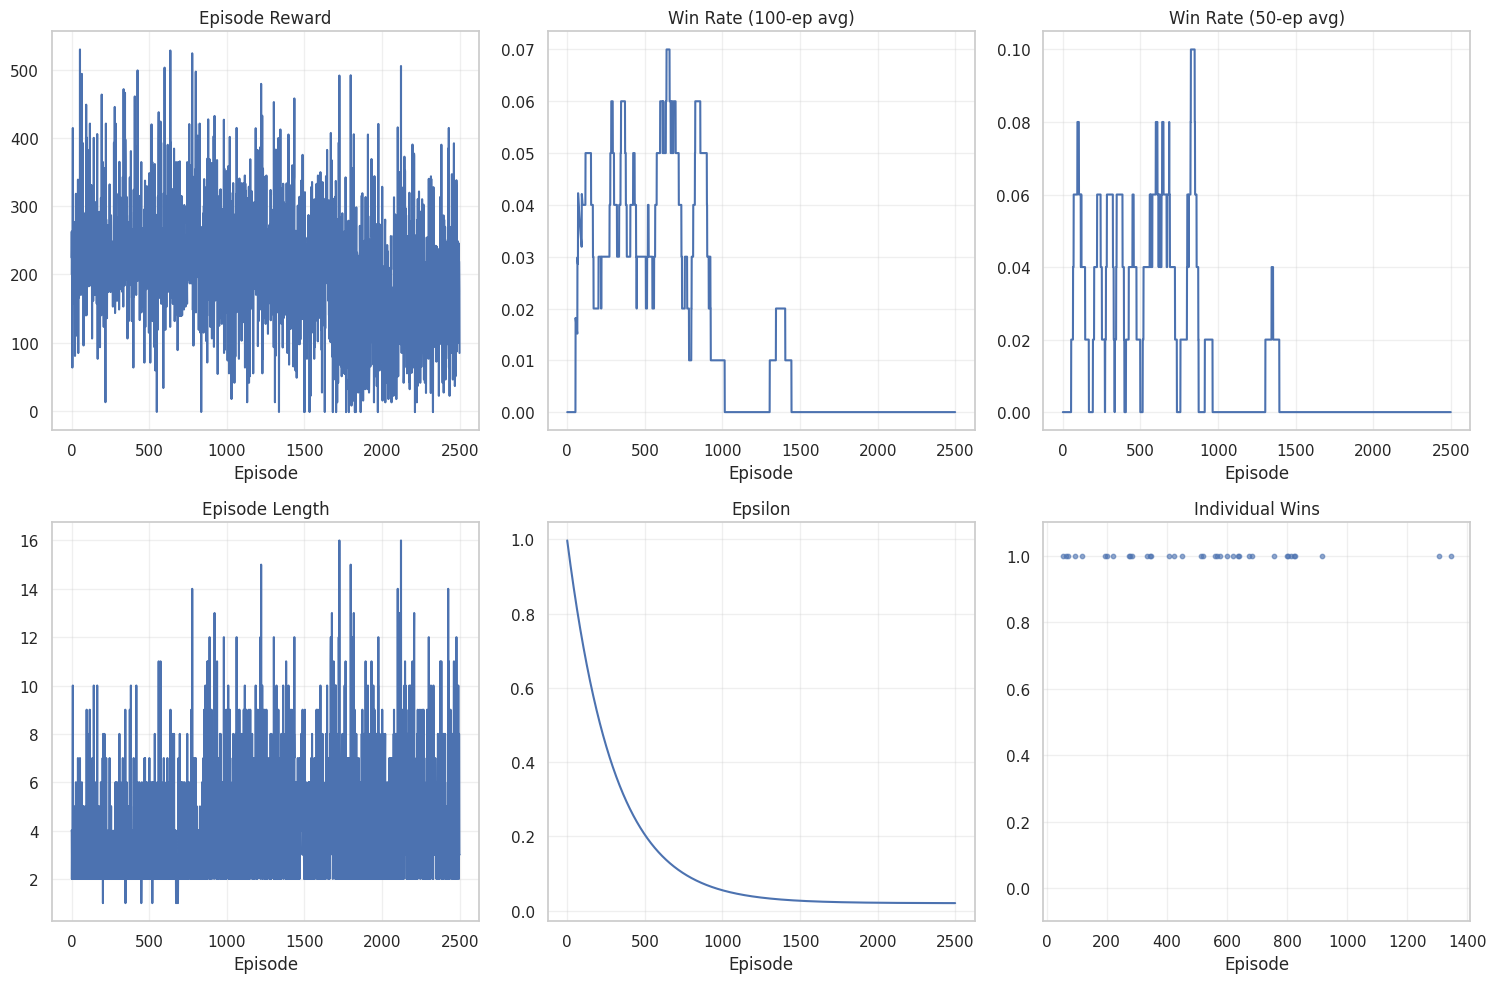


Running final evaluation...
Game 1 failed after 3 steps (reward: 166.9)
* 2 0 0 0 1 □ 1
M 3 0 0 0 1 M □
M 2 0 0 0 1 1 □
□ 2 0 0 0 0 1 □
M 1 1 1 1 0 1 M
□ □ □ M 2 0 1 1
M □ □ M 2 0 0 0
M □ □ □ 1 0 0 0

Game 2 failed after 2 steps (reward: 85.0)
□ □ □ □ □ M □ *
M M □ □ □ 1 2 1
□ □ □ M □ 1 0 0
□ □ □ □ M 1 0 0
□ □ M 2 1 1 0 0
M □ □ 1 0 0 0 0
□ M □ 1 1 0 0 0
□ □ □ M 1 0 0 0

Game 3 failed after 2 steps (reward: 31.7)
□ □ □ □ □ □ □ *
□ □ □ □ □ □ □ □
□ □ □ □ M □ □ M
□ M □ M □ □ 2 1
M □ M □ □ M 1 0
□ □ M □ 2 1 1 0
□ □ □ M 1 0 0 0
□ □ □ □ 1 0 0 0

Game 4 failed after 3 steps (reward: 54.1)
* □ □ M □ □ □ 1
□ □ □ □ M □ □ M
M M □ □ □ □ □ □
□ □ □ □ □ □ □ □
□ □ □ □ □ □ M □
M □ □ M 1 1 1 1
□ M 2 1 1 0 0 0
□ □ 1 0 0 0 0 0

Game 5 failed after 7 steps (reward: 268.2)
2 M 2 □ * M □ 1
M □ □ M 3 2 2 M
□ □ 2 □ 1 0 1 1
□ M □ □ 2 1 0 0
2 □ □ M M 1 0 0
□ M 2 2 2 1 0 0
1 1 1 0 0 0 0 0
0 0 0 0 0 0 0 0

Evaluation over 200 games:
Win Rate: 0.000
Average Steps: 4.5
Average Reward: 175.3
Step Distribution: min=2,

In [26]:
# Train with Enhanced Configuration

HEIGHT = 8
WIDTH = 8
MINES = 10
EPISODES = 2500  # Increased for better convergence

print(f"Training on {HEIGHT}x{WIDTH} board with {MINES} mines")
print(f"Safe cells to reveal: {HEIGHT * WIDTH - MINES}")

# Create environment
env = MinesweeperEnv(height=HEIGHT, width=WIDTH, num_mines=MINES, first_click_safe=True, seed=123)

# Enhanced configuration
config = DQNConfig(
	learning_rate=3e-4,          # Optimized learning rate
	gamma=0.995,                 # Higher discount for long-term planning
	target_update_every=500,     # More frequent target updates
	batch_size=128,              # Larger batch size
	replay_capacity=200_000,     # Much larger replay buffer
	epsilon_start=1.0,
	epsilon_end=0.02,            # Lower minimum epsilon
	epsilon_decay_episodes=1500, # Longer decay period
	conv_channels=64,            # More powerful network
	fc_units=256,
	# Prioritized replay parameters
	alpha=0.6,
	beta_start=0.4,
	beta_end=1.0,
	# Regularization
	gradient_clip=10.0,
	weight_decay=1e-5,
)

print("Configuration:")
print(f"- Network: {config.conv_channels} conv channels, {config.fc_units} FC units")
print(f"- Learning rate: {config.learning_rate}")
print(f"- Replay buffer: {config.replay_capacity:,} experiences")
print(f"- Prioritized replay: α={config.alpha}, β={config.beta_start}→{config.beta_end}")
print(f"- Episodes: {EPISODES} with curriculum learning")
print()

# Train the enhanced agent
agent, history = train_enhanced_agent(
	env,
	episodes=EPISODES,
	warmup_steps=2000,           # Longer warmup for better exploration
	max_steps_per_episode=None,
	config=config,
	show_progress_every=100,
	curriculum_learning=True,    # Enable curriculum learning
)

print("\nTraining completed!")
print(f"Final win rate (last 100): {np.mean(history['win'][-100:]):.3f}")
print(f"Final win rate (last 50): {np.mean(history['win'][-50:]):.3f}")
print(f"Best 50-episode win rate: {max(history['win_rate_50']):.3f}")

# Plot enhanced training curves
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
metrics = [
	("episode_reward", "Episode Reward"),
	("win_rate", "Win Rate (100-ep avg)"),
	("win_rate_50", "Win Rate (50-ep avg)"),
	("episode_length", "Episode Length"),
	("epsilon", "Epsilon"),
	("win", "Individual Wins")
]

for ax, (k, title) in zip(axes.ravel(), metrics):
	if k in history:
		if k == "win":
			# Show wins as scatter plot
			wins = np.array(history[k])
			win_indices = np.where(wins == 1)[0]
			ax.scatter(win_indices, wins[win_indices], alpha=0.6, s=10)
			ax.set_ylim(-0.1, 1.1)
		else:
			ax.plot(history[k])
		ax.set_title(title)
		ax.set_xlabel("Episode")
		ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Comprehensive evaluation
print("\nRunning final evaluation...")
final_win_rate, avg_steps, avg_reward = evaluate_agent(env, agent, num_games=200, render_failures=True)

Running detailed evaluation...

Detailed Evaluation Results (50 games):
Win rate: 0.000 (0/50)
Average steps: 4.2 ± 1.9
Average reward: 171.0 ± 72.6

Failure analysis:
  Mid game failure: 22/50 (44.0%)
  Late game failure: 27/50 (54.0%)
  Early game failure: 1/50 (2.0%)

Showing example game (interactive visualization):
Example game: Win=False, Steps=3, Total Reward=75.8
Game successful - showing first few steps...


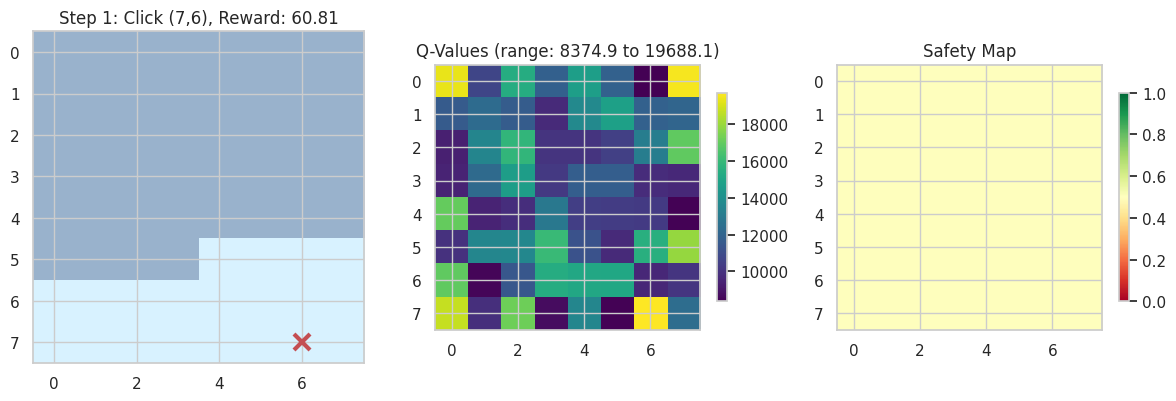

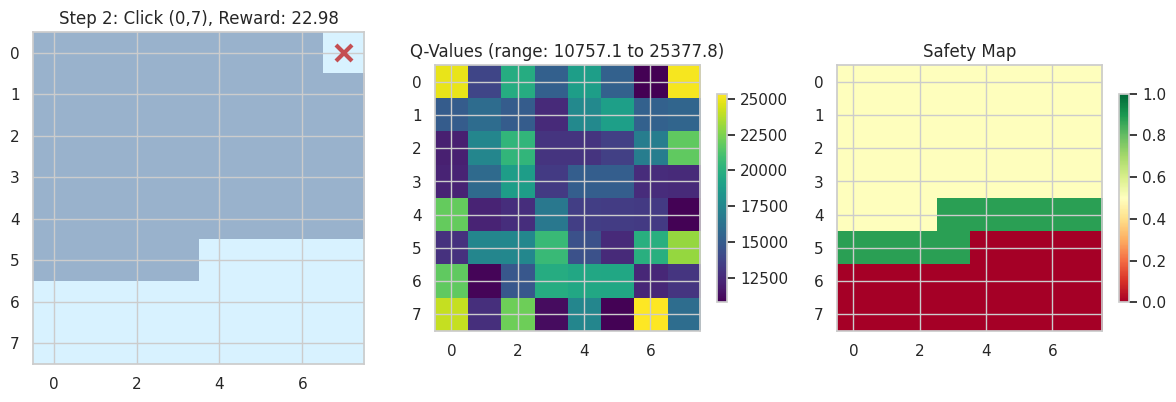

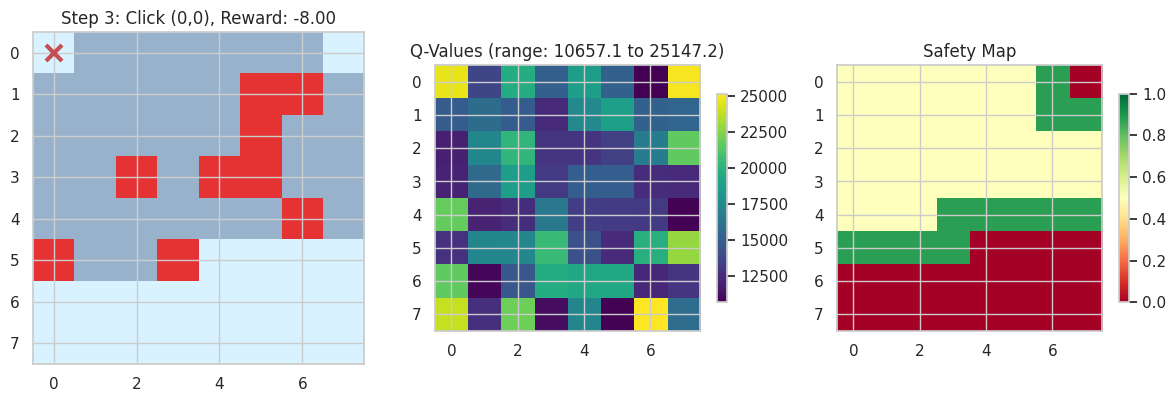

In [28]:
# Enhanced Evaluation and Gameplay Visualization

def greedy_action_enhanced(agent, state, env):
	"""Enhanced action selection with safety consideration"""
	mask = env.valid_action_mask()
	q = agent.online.predict(state[None, ...], verbose=0)[0]
	
	# Add slight safety bias to Q-values
	safety_scores = state[..., 11].flatten()
	safety_bias = safety_scores * 0.05
	
	q_with_safety = np.where(mask > 0.5, q + safety_bias, -1e9)
	action = int(np.argmax(q_with_safety))
	
	return action, q.reshape(env.height, env.width), safety_scores.reshape(env.height, env.width)


def play_enhanced_game(env, agent, render_each=False, delay=0.0, collect_frames=False):
	"""Play a single game with enhanced tracking"""
	state = env.reset()
	frames = []
	qmaps = []
	safety_maps = []
	actions_taken = []
	rewards_received = []
	steps = 0
	
	while not env.done and steps < env.height * env.width * 2:
		action, q_map, safety_map = greedy_action_enhanced(agent, state, env)
		r, c = divmod(action, env.width)
		
		state, reward, done, _ = env.step(action)
		
		actions_taken.append((r, c))
		rewards_received.append(reward)
		
		if collect_frames or render_each:
			frames.append(render_board_image(env))
			qmaps.append(q_map)
			safety_maps.append(safety_map)
			
			if render_each:
				fig, axes = plt.subplots(1, 3, figsize=(12, 4))
				
				# Board state
				axes[0].imshow(frames[-1])
				axes[0].set_title(f"Step {steps+1}: Click ({r},{c})")
				axes[0].plot(c, r, 'rx', markersize=10, markeredgewidth=2)
				
				# Q-values
				im1 = axes[1].imshow(qmaps[-1], cmap="viridis")
				axes[1].set_title(f"Q-Values (max: {qmaps[-1].max():.2f})")
				plt.colorbar(im1, ax=axes[1])
				
				# Safety map
				im2 = axes[2].imshow(safety_maps[-1], cmap="RdYlGn")
				axes[2].set_title("Safety Scores")
				plt.colorbar(im2, ax=axes[2])
				
				plt.tight_layout()
				plt.show()
				time.sleep(delay)
		
		steps += 1
	
	win = env.done and env.revealed_safe >= env.num_safe_cells
	total_reward = sum(rewards_received)
	
	return win, steps, total_reward, frames, qmaps, safety_maps, actions_taken, rewards_received


# Run detailed evaluation games
print("Running detailed evaluation...")
N_EVAL = 50
wins = 0
all_steps = []
all_rewards = []
failure_reasons = []

for i in range(N_EVAL):
	win, steps, total_reward, _, _, _, actions, rewards = play_enhanced_game(env, agent)
	wins += int(win)
	all_steps.append(steps)
	all_rewards.append(total_reward)
	
	if not win:
		# Analyze failure
		if env.revealed_safe == 0:
			failure_reasons.append("First click mine")
		elif env.revealed_safe < env.num_safe_cells * 0.3:
			failure_reasons.append("Early game failure")
		elif env.revealed_safe < env.num_safe_cells * 0.7:
			failure_reasons.append("Mid game failure")
		else:
			failure_reasons.append("Late game failure")

print(f"\nDetailed Evaluation Results ({N_EVAL} games):")
print(f"Win rate: {wins/N_EVAL:.3f} ({wins}/{N_EVAL})")
print(f"Average steps: {np.mean(all_steps):.1f} ± {np.std(all_steps):.1f}")
print(f"Average reward: {np.mean(all_rewards):.1f} ± {np.std(all_rewards):.1f}")

if failure_reasons:
	from collections import Counter
	failure_counts = Counter(failure_reasons)
	print(f"\nFailure analysis:")
	for reason, count in failure_counts.items():
		print(f"  {reason}: {count}/{len(failure_reasons)} ({count/len(failure_reasons)*100:.1f}%)")

# Show example successful game
print(f"\nShowing example game (interactive visualization):")
win, steps, total_reward, frames, qmaps, safety_maps, actions, rewards = play_enhanced_game(
	env, agent, collect_frames=True
)
print(f"Example game: Win={win}, Steps={steps}, Total Reward={total_reward:.1f}")

if len(frames) > 0:
	print("Game successful - showing first few steps...")
	for i in range(min(3, len(frames))):
		r, c = actions[i]
		reward = rewards[i]
		
		fig, axes = plt.subplots(1, 3, figsize=(12, 4))
		
		# Board
		axes[0].imshow(frames[i])
		axes[0].set_title(f"Step {i+1}: Click ({r},{c}), Reward: {reward:.2f}")
		axes[0].plot(c, r, 'rx', markersize=12, markeredgewidth=3)
		
		# Q-values
		im1 = axes[1].imshow(qmaps[i], cmap="viridis")
		axes[1].set_title(f"Q-Values (range: {qmaps[i].min():.1f} to {qmaps[i].max():.1f})")
		plt.colorbar(im1, ax=axes[1], shrink=0.6)
		
		# Safety
		im2 = axes[2].imshow(safety_maps[i], cmap="RdYlGn", vmin=0, vmax=1)
		axes[2].set_title("Safety Map")
		plt.colorbar(im2, ax=axes[2], shrink=0.6)
		
		plt.tight_layout()
		plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


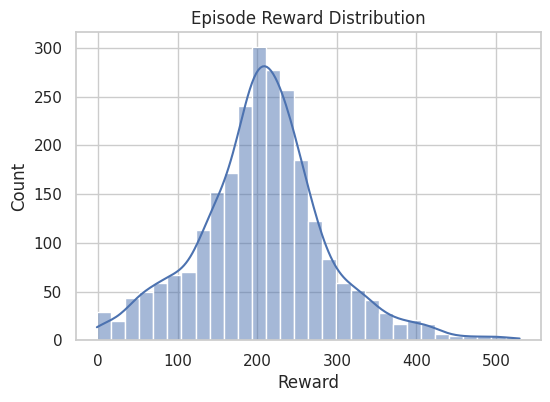

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


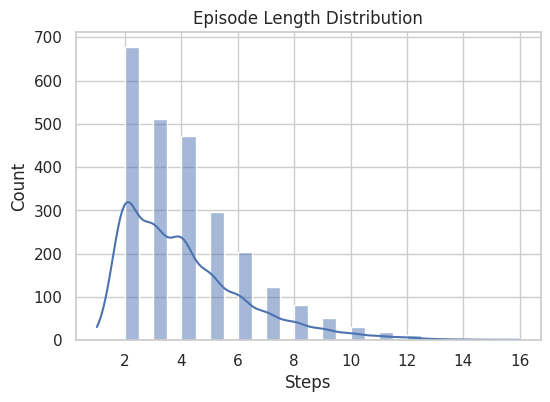

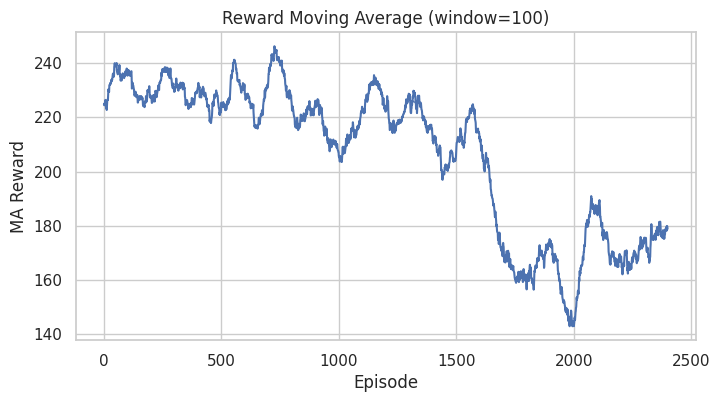

In [30]:
# Extra visualizations: distributions and moving averages

# Rewards distribution
plt.figure(figsize=(6,4))
sns.histplot(history["episode_reward"], bins=30, kde=True)
plt.title("Episode Reward Distribution")
plt.xlabel("Reward")
plt.show()

# Episode length distribution
plt.figure(figsize=(6,4))
sns.histplot(history["episode_length"], bins=30, kde=True)
plt.title("Episode Length Distribution")
plt.xlabel("Steps")
plt.show()

# Moving average of rewards
window = min(100, max(10, len(history["episode_reward"]) // 10))
ma = np.convolve(np.array(history["episode_reward"], dtype=np.float32), np.ones(window)/window, mode='valid')
plt.figure(figsize=(8,4))
plt.plot(ma)
plt.title(f"Reward Moving Average (window={window})")
plt.xlabel("Episode")
plt.ylabel("MA Reward")
plt.grid(True)
plt.show()


### Notes

there is still a lot fo room for improvement as i cannot get the models to actually win, but ill solve the problem!
